# Evaluation of CCLM testruns with ERA5 for individual point data

In [1]:
import valenspy as vp
import xarray as xr
from pathlib import Path
import cdo 
from yaml import safe_load
import os
import matplotlib.pyplot as plt
 
from eval_functions import *

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

model = "CCLM"

# postprocessing base directory 
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

src_path = Path("../src/valenspy")


In [2]:
# reference dataset to compare to
ref_dataset = 'ERA5'


# secondary list of variables to compare
# cloud characteristics (integrated cloud water, ice, graupel, snow and rain) (NOT YET IN CORDEX_VARIABLES list)
# ERA5-land: surface fluxes: latent heat, sensible heat

# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

### 1. Load preprocessed CCLM data

In [3]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TE_GC_TSO", 
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]

experiment = experiments[0]

proc_dir = postproc_base_dir + experiment

with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)


In [4]:
# do selection of individual points (do this in separate notebook.)
# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'bertrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']


months_to_analyse = [5,6]


### Identify neigbouring grid cells

In [5]:


def get_surrounding_grid_cells(ds, rlon_val, rlat_val):
    """
    Extracts a 3x3 grid of cells surrounding the grid cell closest to the given rlon and rlat values.
    
    Parameters:
    ds (xarray.Dataset): The input dataset containing rlon and rlat coordinates.
    rlon_val (float): The rlon value for which to find the surrounding grid cells.
    rlat_val (float): The rlat value for which to find the surrounding grid cells.
    
    Returns:
    xarray.Dataset: A subset of the original dataset containing the 3x3 grid cells surrounding the nearest grid cell.
    """
    # Step 1: Find the nearest grid cell indices
    nearest_rlon_idx = (abs(ds.rlon - rlon_val)).argmin().item()
    nearest_rlat_idx = (abs(ds.rlat - rlat_val)).argmin().item()

    # Step 2: Create slices for the surrounding grid cells
    rlon_slice = slice(nearest_rlon_idx - 1, nearest_rlon_idx + 2)
    rlat_slice = slice(nearest_rlat_idx - 1, nearest_rlat_idx + 2)

    # Step 3: Extract the subset of the dataset
    subset = ds.isel(rlon=rlon_slice, rlat=rlat_slice)
    
    return subset


def identify_surrounding_gridcells(variable: str,  experiments: list, point_coord: tuple): 

    # open the CCLM file for the corresponding variable
    mod_var = mod_LOOKUP[variable]['mod_name']
    directory = Path(postproc_base_dir + experiments[0] +'/'+mod_var + '/')
    mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory
    ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

    # Get the lon lat coordinates of the 9 gridcells surrounding the point, from CCLM rotated coordinates
    coord_points_rotated = geo_to_rot(point_coord, ds_mod)

    ds_9_points = get_surrounding_grid_cells(ds_mod, coord_points_rotated[0], coord_points_rotated[1])

    # based on rlons and rlats get the lon lats of the 9 points
    d_neigbouring_points = {}
    for n,i in enumerate(ds_9_points.rlat): 
        for k,j in enumerate(ds_9_points.rlon): 

            point_9_coord = (float(ds_9_points.sel(rlat=i,rlon=j).lon.values), float(ds_9_points.sel(rlat=i,rlon=j).lat.values))
            d_neigbouring_points[f"{k+1},{n+1}"] = point_9_coord
    return d_neigbouring_points
        

In [6]:
def plot_point_timeseries_topo(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list): 

    ## OROGRAPHY
    # load orography of ERA5 and select point
    orography_era5_file = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/fx/era5-orography.nc'
    ds_orography_era5 = xr.open_mfdataset(orography_era5_file, combine="by_coords", chunks="auto")

    # Earth gravitational acceleration
    g = 9.80665 # m s-2
    # calculate orography (m) by dividing the surface geopotential height by the Earth gravitational acceleration
    da_obs_topography = (ds_orography_era5["z"] / g).squeeze().rename({'latitude' : 'lat', 'longitude' : 'lon'})
    da_obs_topography_point = da_obs_topography.sel(lon=point_coord[0],lat=point_coord[1], method='nearest').values
    ## load orography of CCLM and select point 
    # define the path
    directory = Path(postproc_base_dir + experiments[0] +'/')
    # define the CCLM files for the corresponding variable
    cst_file = list(directory.glob("*c.nc")) # Select all the netCDF files in the directory
    ds_mod_cst = xr.open_mfdataset(cst_file, combine="by_coords", chunks="auto")
    # get altitude
    da_mod_topography = ds_mod_cst["HSURF"]
    coord_points_rotated = geo_to_rot(point_coord, ds_mod_cst)
    da_mod_topography_point = da_mod_topography.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest').values[0]


    ## VARIABLE

    # start up input manager
    manager = vp.InputManager(machine=machine)

    # use input manager to load data, defined on settings above
    ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])

    # select point 
    ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 
        # get CCLM variable corresponding to the requested variable using its look-up table
        mod_var = mod_LOOKUP[variable]['mod_name']

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

        # open the CCLM file for the corresponding variable
        mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        if not mod_files:  # empty list - move to next element in loop
            print(f"{variable} not available for {experiment}")
            continue
            
        ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

        coord_points_rotated = geo_to_rot(point_coord, ds_mod)
        ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

        da_mod_point = ds_mod_point[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    fig, ax = plt.subplots(figsize = (7,3))

    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title(da_obs_point.attrs['long_name'], loc='left')
    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]:.2f}°N,  {point_coord[0]:.2f}°E)", loc='right'); 
    ax.text(0.05, 0.95, f"Altitude CCLM: {da_mod_topography_point:.0f} m\nAltitude ERA5: {da_obs_topography_point:.0f} m",
            transform=plt.gca().transAxes,
            verticalalignment='top')

    #fig.savefig(f"./plots/timeseries_{variable}_{point_coord[1]}N_{point_coord[0]}E).png")

### Plotting

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']
tas not available for EUR11_NU_TE_GC_TSO
tas not available for EUR11_NU_TT_GC_TSO


TypeError: No numeric data to plot.

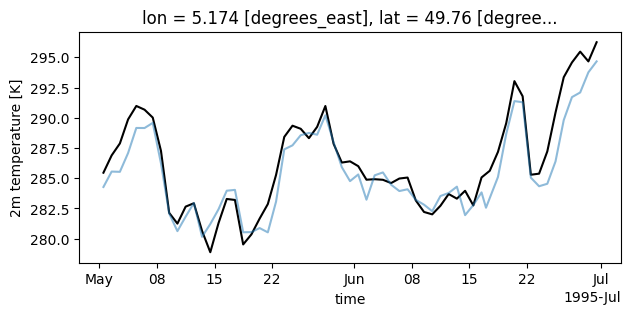

In [7]:
# variables of interest
variable = "tas"
region = 'europe'
point_id = "bertrix"


# identify the surrouding grid cells 

d_neigbouring_points = identify_surrounding_gridcells(variable,  experiments, d_point_coords[point_id])

for point_id in d_neigbouring_points: 

    plot_point_timeseries_topo(variable, ref_dataset, experiments, d_neigbouring_points[point_id], point_id,  months_to_analyse)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']
tas not available for EUR11_CO_TE_GC_TSO
tas not available for EUR11_CO_TT_EC_TSO
tas not available for EUR11_NU_TE_GC_TSO
tas not available for EUR11_NU_TT_GC_TSO
tas not available for EUR11_NU_TT_EC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']
tas not available for EUR11_CO_TE_GC_TSO
tas not available for EUR11_CO_TT_EC_TSO
tas not available for EUR11_NU_TE_GC_TSO
tas not available for EUR11_NU_TT_GC_TSO
tas n

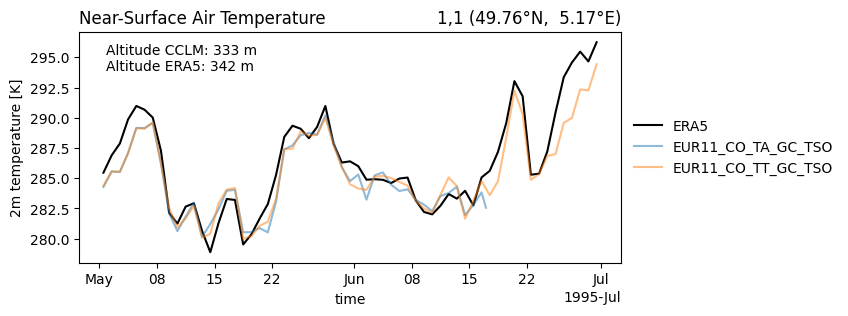

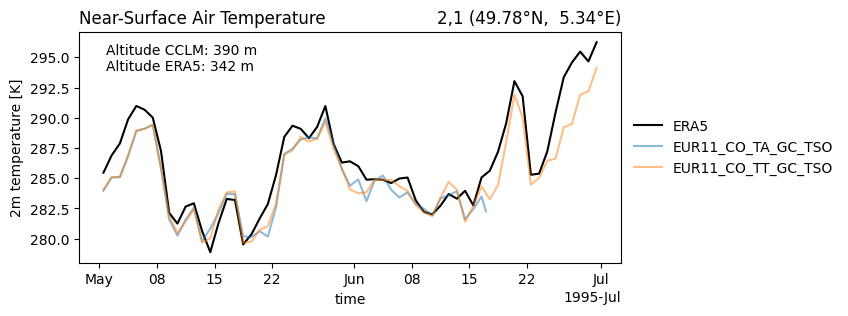

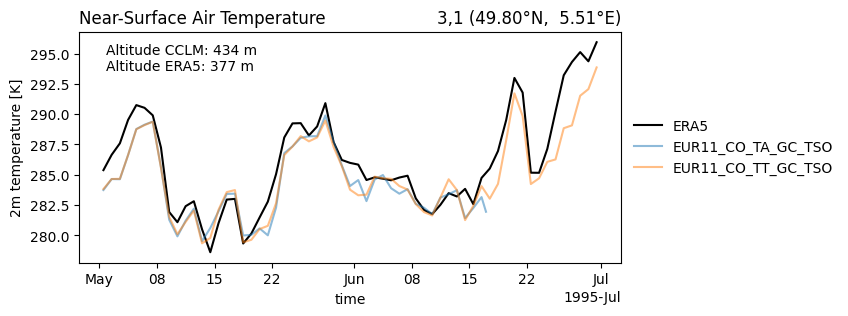

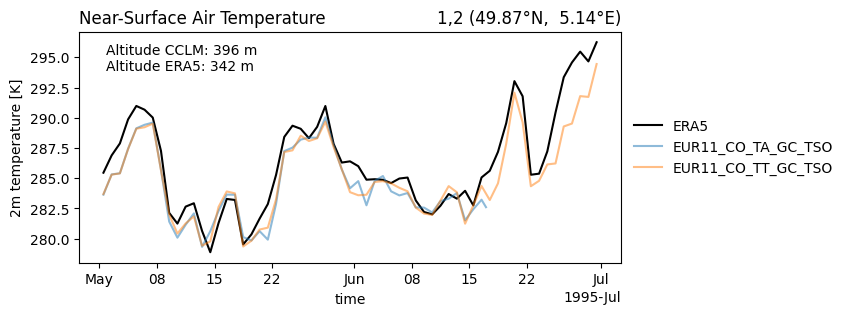

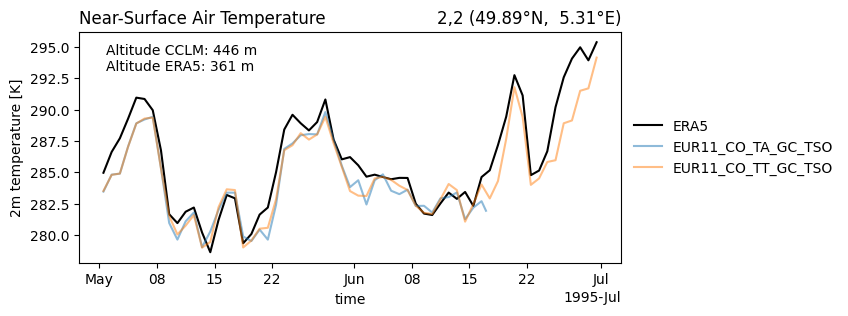

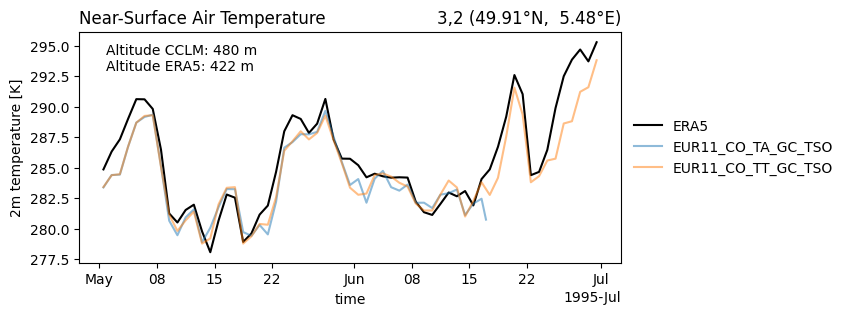

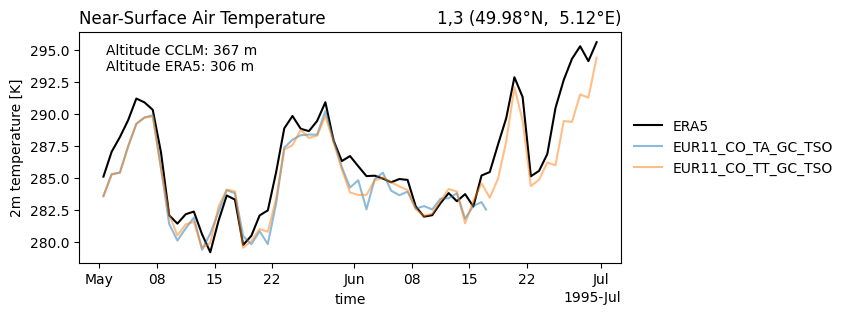

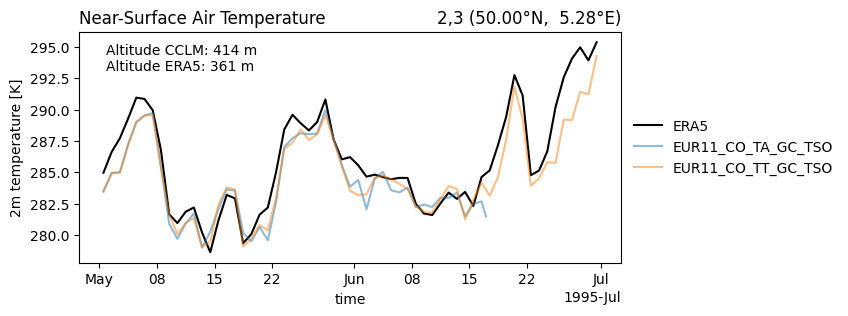

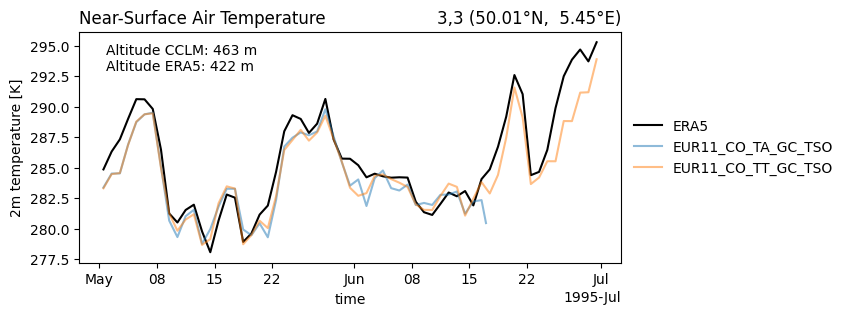

In [ ]:
# variables of interest
variable = "tas"
region = 'europe'
point_id = "opwijk"


# identify the surrouding grid cells 

d_neigbouring_points = identify_surrounding_gridcells(variable,  experiments, d_point_coords[point_id])

for point_id in d_neigbouring_points: 

    plot_point_timeseries_topo(variable, ref_dataset, experiments, d_neigbouring_points[point_id], point_id,  months_to_analyse)

In [8]:
# variables of interest
variable = "ts"
region = 'europe'
point_id = "bertrix"
ref_dataset = "ERA5-Land"

# identify the surrouding grid cells 

d_neigbouring_points = identify_surrounding_gridcells(variable,  experiments, d_point_coords[point_id])

for point_id in d_neigbouring_points: 

    plot_point_timeseries_topo(variable, ref_dataset, experiments, d_neigbouring_points[point_id], point_id,  months_to_analyse)

OSError: no files to open

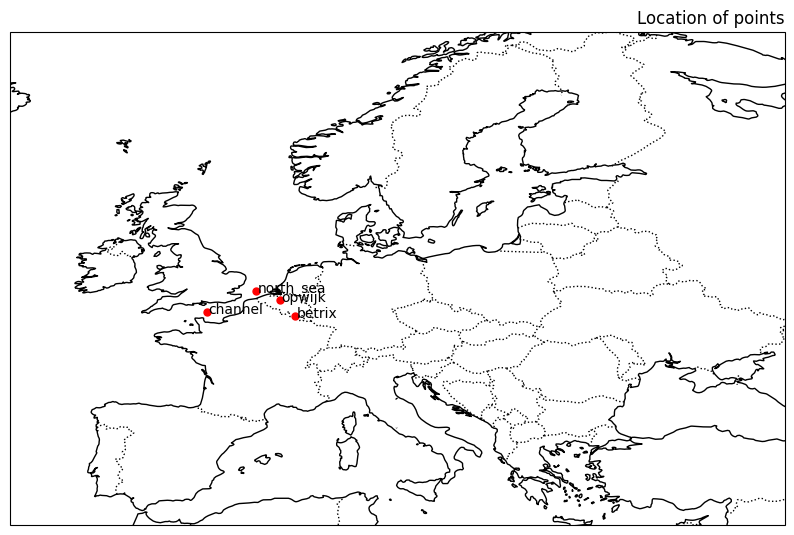

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'europe'

def plot_points_map(d_coord_points: dict, region: str, bounds: str): 

    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot each point and add a label
    for key, (lon, lat) in d_coord_points.items():
        ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat - 0.1, key, transform=ccrs.PlateCarree())

    # Set extent if needed (optional)
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    ax.set_title('Location of points', loc='right')
    # Show the plot
    plt.show()
    fig.savefig("./plots/points_map.png")


plot_points_map(d_coord_points, region, bounds)